<a href="https://colab.research.google.com/github/sandeeppalakkal/ML_Datascience_Practice/blob/master/CIFAR10_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Get CIFAR10 data
def get_cifar10(train_transform=None, val_transform=None):
  trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transform)
  valset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=val_transform)
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return trainset, valset, classes

In [3]:
def dataloader(batch_size, transform=None):
  if transform == None:
    train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(3*[0.5], 3*[0.5])])
    val_transform = train_transform
  else:
    assert isinstance(transform, (tuple, list)), "transform should be a tupe or list of train & validation transforms"
    train_transform = transform[0]
    val_transform = transform[1]
  trainset,valset, classes = get_cifar10(train_transform, val_transform)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, num_workers=2)
  return train_loader, val_loader, classes

# Training Module

In [4]:
def test(val_loader, net, criterion, device):
  # since we're not training, we don't need to calculate the gradients for our outputs
  running_loss,correct,total = 0.0,0,0
  net.eval()
  with torch.no_grad():
    for data in val_loader:
      images, labels = data[0].to(device), data[1].to(device)
      # calculate outputs by running images through the network
      outputs = net(images)
      running_loss += criterion(outputs, labels).item()
      # the class with the highest energy is what we choose as prediction
      predicted = torch.argmax(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  loss = running_loss/len(val_loader)
  return loss, acc

def train_epoch(train_loader,net,criterion,optimizer,device):
  '''Train data for one epoch'''
  running_loss,correct,total = 0.0,0,0
  net.train()
  for i, data in enumerate(train_loader):
    images,labels = data[0].to(device),data[1].to(device)
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    predictions = torch.argmax(outputs.data, 1)
    correct += (predictions == labels).float().sum().item()
    total += labels.size(0)
  loss = running_loss / len(train_loader)
  acc = correct / total * 100
  return loss, acc

def train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device,scheduler=None):
  # start training
  train_losses = []
  train_acc = []
  val_losses = []
  val_acc = []
  for epoch in range(n_epochs):
    # Run training on one epoch
    loss_, acc_ = train_epoch(train_loader, net, criterion, optimizer, device)
    if scheduler is not None:
      scheduler.step()
    train_acc.append(acc_)
    train_losses.append(loss_)

    # Test model
    val_losses_, val_acc_ = test(val_loader, net, criterion, device)
    val_acc.append(val_acc_)
    val_losses.append(val_losses_)

    print(f'[Epoch: {epoch + 1}] \
    train loss: {train_losses[-1]:.3f}; val loss: {val_losses[-1]:.3f}; \
    train accuracy: {train_acc[-1]:.2f}%; test accuracy: {val_acc[-1]:.2f}%') 

  print('Finished Training')
  return train_losses, train_acc, val_losses, val_acc

# Plot Loss

In [5]:
# Plot loss
import matplotlib.pyplot as plt
def plot_losses(train_losses, val_losses, train_acc, val_acc):
  plt.plot(train_losses,label='train loss')
  plt.plot(val_losses,label='val loss')
  plt.legend()
  plt.grid()
  plt.show()
  plt.plot(train_acc, label='train acc')
  plt.plot(val_acc, label='val acc')
  plt.legend()
  plt.grid()
  plt.show()

# Define Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class Net3(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding='same')
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(16,16,3,padding='same')
    self.conv3 = nn.Conv2d(16,16,3,padding='same')
    self.fc1 = nn.Linear(16*4*4,256)
    self.fc2 = nn.Linear(256,64)
    self.fc3 = nn.Linear(64,10)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

In [ ]:
class Net4(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding='same')
    self.bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(16,16,3,padding='same')
    self.bn2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16,16,3,padding='same')
    self.bn3 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16*4*4,256)
    self.fc2 = nn.Linear(256,64)
    self.fc3 = nn.Linear(64,10)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

In [9]:
class Net5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding='same')
    self.bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(16,16,3,padding='same')
    self.bn2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16,16,3,padding='same')
    self.bn3 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16*4*4,256)
    self.fc2 = nn.Linear(256,64)
    self.fc3 = nn.Linear(64,10)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(self.bn1(F.relu(self.conv1(x))))
    x = self.pool(self.bn2(F.relu(self.conv2(x))))
    x = self.pool(self.bn3(F.relu(self.conv3(x))))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

In [7]:
class Net6(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding='same')
    self.bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(16,32,3,padding='same')
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,64,3,padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(64*4*4,1024)
    self.fc2 = nn.Linear(1024,1024)
    self.fc3 = nn.Linear(1024,10)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(self.bn1(F.relu(self.conv1(x))))
    x = self.pool(self.bn2(F.relu(self.conv2(x))))
    x = self.pool(self.bn3(F.relu(self.conv3(x))))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

# Train Model

In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
lr = 0.001
momentum = 0.9
batch_size = 32
n_epochs = 50

In [ ]:
# Data loader
train_loader,val_loader,classes = dataloader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# define network for training
net = Net1().to(device)

In [ ]:
# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

In [ ]:
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

[Epoch: 1]     train loss: 2.287; val loss: 2.194     train accuracy: 13.62%; test accuracy: 19.19%
[Epoch: 2]     train loss: 1.926; val loss: 1.712     train accuracy: 28.91%; test accuracy: 36.41%
[Epoch: 3]     train loss: 1.631; val loss: 1.538     train accuracy: 39.79%; test accuracy: 43.45%
[Epoch: 4]     train loss: 1.507; val loss: 1.439     train accuracy: 45.03%; test accuracy: 47.25%
[Epoch: 5]     train loss: 1.408; val loss: 1.357     train accuracy: 48.66%; test accuracy: 51.12%
[Epoch: 6]     train loss: 1.336; val loss: 1.331     train accuracy: 51.73%; test accuracy: 52.24%
[Epoch: 7]     train loss: 1.271; val loss: 1.265     train accuracy: 54.39%; test accuracy: 54.60%
[Epoch: 8]     train loss: 1.212; val loss: 1.206     train accuracy: 56.61%; test accuracy: 56.93%
[Epoch: 9]     train loss: 1.164; val loss: 1.210     train accuracy: 58.55%; test accuracy: 57.18%
[Epoch: 10]     train loss: 1.119; val loss: 1.140     train accuracy: 60.36%; test accuracy: 60.12%

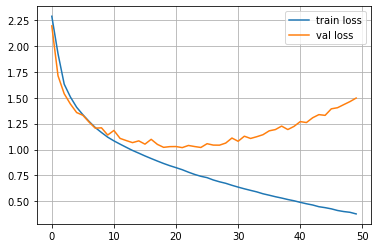

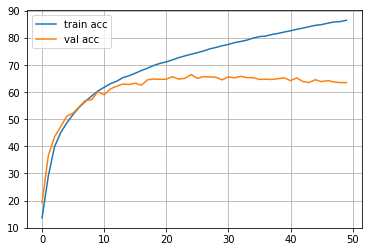

In [ ]:
plot_losses(losses, val_losses, acc, val_acc)

**Conclusion:** model is over-fitting to training set

# 2nd Training: Dropout

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./root/cifar-10-python.tar.gz to ./root


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[Epoch: 1]     train loss: 2.219; val loss: 2.010;     train accuracy: 16.90%; test accuracy: 25.22%
[Epoch: 2]     train loss: 1.893; val loss: 1.750;     train accuracy: 29.73%; test accuracy: 35.53%
[Epoch: 3]     train loss: 1.670; val loss: 1.599;     train accuracy: 38.59%; test accuracy: 41.80%
[Epoch: 4]     train loss: 1.555; val loss: 1.505;     train accuracy: 43.14%; test accuracy: 44.87%
[Epoch: 5]     train loss: 1.481; val loss: 1.442;     train accuracy: 45.96%; test accuracy: 48.01%
[Epoch: 6]     train loss: 1.417; val loss: 1.398;     train accuracy: 48.47%; test accuracy: 49.00%
[Epoch: 7]     train loss: 1.357; val loss: 1.332;     train accuracy: 50.95%; test accuracy: 51.67%
[Epoch: 8]     train loss: 1.308; val loss: 1.309;     train accuracy: 53.02%; test accuracy: 53.04%
[Epoch: 9]     train loss: 1.268; val loss: 1.301;     train accuracy: 54.28%; test accuracy: 52.84%
[Epoch: 10]     train loss: 1.230; val l

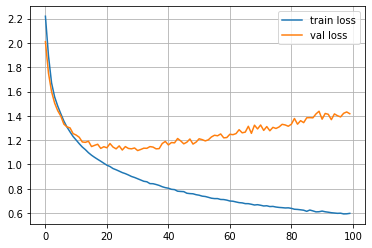

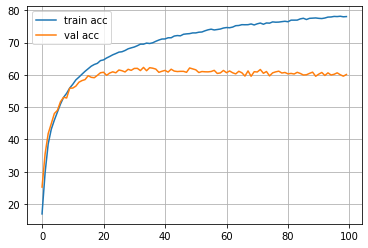

In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data loader
train_loader,val_loader,classes = dataloader(batch_size)

# define network for training
net = Net2().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

**Conclusion:** Though over-fitting reduced, the test accuracy went down. Hyper-param tuning (lr, etc.) may be required to improve accuracy further.

# Experiment 3: Better Model

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Epoch: 1]     train loss: 2.301; val loss: 2.296;     train accuracy: 11.09%; test accuracy: 12.92%
[Epoch: 2]     train loss: 2.221; val loss: 2.040;     train accuracy: 17.72%; test accuracy: 25.54%
[Epoch: 3]     train loss: 1.903; val loss: 1.766;     train accuracy: 29.68%; test accuracy: 34.41%
[Epoch: 4]     train loss: 1.679; val loss: 1.593;     train accuracy: 37.86%; test accuracy: 41.07%
[Epoch: 5]     train loss: 1.574; val loss: 1.527;     train accuracy: 41.97%; test accuracy: 44.60%
[Epoch: 6]     train loss: 1.502; val loss: 1.447;     train accuracy: 45.13%; test accuracy: 46.84%
[Epoch: 7]     train loss: 1.441; val loss: 1.398;     train accuracy: 47.46%; test accuracy: 48.57%
[Epoch: 8]     train loss: 1.378; val loss: 1.363;     train accuracy: 49.90%; test accuracy: 51.25%
[Epoch: 9]     train loss: 1.321; val loss: 1.307;     train accuracy: 52.24%; test accuracy: 53.34%
[E

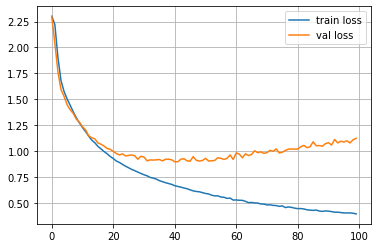

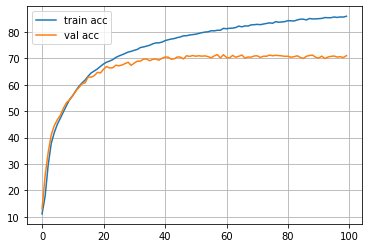

max train acc: 85.988	 max test acc: 71.45


In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data loader
train_loader,val_loader,classes = dataloader(batch_size)

# define network for training
net = Net3().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

**Conclusion:** Better model & dropout are helping, but over-fitting is still observed since the test loss increases after a point. To reduce over-fitting further, data augmentation must be tried.

# Experiment 4: Better Model: Faster Learning Rate

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 2.025; val loss: 1.623;     train accuracy: 24.63%; test accuracy: 40.60%
[Epoch: 2]     train loss: 1.562; val loss: 1.360;     train accuracy: 42.50%; test accuracy: 50.57%
[Epoch: 3]     train loss: 1.367; val loss: 1.223;     train accuracy: 50.54%; test accuracy: 55.73%
[Epoch: 4]     train loss: 1.235; val loss: 1.131;     train accuracy: 55.82%; test accuracy: 59.39%
[Epoch: 5]     train loss: 1.134; val loss: 1.042;     train accuracy: 60.16%; test accuracy: 62.95%
[Epoch: 6]     train loss: 1.063; val loss: 1.004;     train accuracy: 62.87%; test accuracy: 65.15%
[Epoch: 7]     train loss: 1.001; val loss: 0.973;     train accuracy: 65.21%; test accuracy: 65.75%
[Epoch: 8]     train loss: 0.966; val loss: 0.942;     train accuracy: 66.44%; test accuracy: 67.07%
[Epoch: 9]     train loss: 0.930; val loss: 0.907;     train accuracy: 67.73%; test accuracy: 67.90%
[Epoch: 10]    

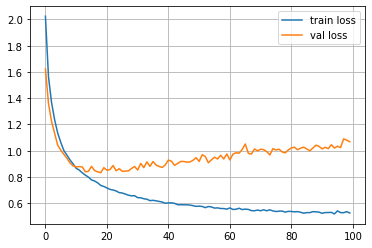

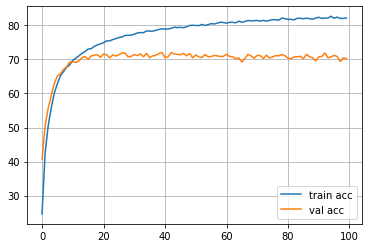

max train acc: 82.678	 max test acc: 72.01


In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data loader
train_loader,val_loader,classes = dataloader(batch_size)

# define network for training
net = Net3().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

# Experiment 5: Better Model: Data Augmentation

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 2.044; val loss: 1.620;     train accuracy: 23.34%; test accuracy: 41.20%
[Epoch: 2]     train loss: 1.625; val loss: 1.372;     train accuracy: 40.43%; test accuracy: 48.72%
[Epoch: 3]     train loss: 1.461; val loss: 1.301;     train accuracy: 46.64%; test accuracy: 51.67%
[Epoch: 4]     train loss: 1.360; val loss: 1.165;     train accuracy: 50.82%; test accuracy: 57.99%
[Epoch: 5]     train loss: 1.288; val loss: 1.105;     train accuracy: 53.82%; test accuracy: 60.88%
[Epoch: 6]     train loss: 1.245; val loss: 1.045;     train accuracy: 55.68%; test accuracy: 62.98%
[Epoch: 7]     train loss: 1.190; val loss: 1.049;     train accuracy: 57.91%; test accuracy: 62.84%
[Epoch: 8]     train loss: 1.152; val loss: 0.993;     train accuracy: 59.30%; test accuracy: 65.09%
[Epoch: 9]     train loss: 1.128; val loss: 0.971;     train accuracy: 60.32%; test accuracy: 65.72%
[Epoch: 10]    

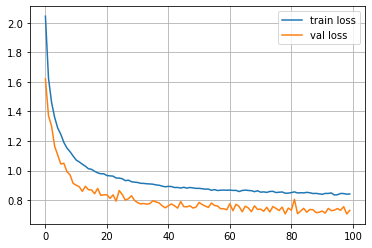

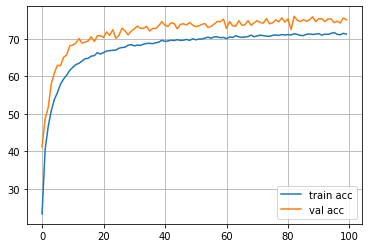

max train acc: 71.706	 max test acc: 76.03


In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data augmentation
stats = (3*[0.5],3*[0.5])
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# Data loader
train_loader,val_loader,classes = dataloader(batch_size, transform=(train_tfms,valid_tfms))

# define network for training
net = Net3().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

**Conclusion:** Data augmentation has helped in enabling the model to learn better. However, training loss is slowly going down still. Adding batch-normalization may help improving the speed of convergence.

# Experiment 6: Better Model: Data Augmentation + BatchNorm

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 1.675; val loss: 1.293;     train accuracy: 37.60%; test accuracy: 53.24%
[Epoch: 2]     train loss: 1.366; val loss: 1.101;     train accuracy: 50.79%; test accuracy: 60.87%
[Epoch: 3]     train loss: 1.240; val loss: 1.059;     train accuracy: 55.98%; test accuracy: 61.72%
[Epoch: 4]     train loss: 1.172; val loss: 1.012;     train accuracy: 58.42%; test accuracy: 63.84%
[Epoch: 5]     train loss: 1.116; val loss: 0.994;     train accuracy: 60.99%; test accuracy: 64.73%
[Epoch: 6]     train loss: 1.083; val loss: 1.028;     train accuracy: 61.91%; test accuracy: 64.42%
[Epoch: 7]     train loss: 1.056; val loss: 0.872;     train accuracy: 63.02%; test accuracy: 68.98%
[Epoch: 8]     train loss: 1.027; val loss: 0.912;     train accuracy: 64.25%; test accuracy: 67.87%
[Epoch: 9]     train loss: 1.014; val loss: 0.847;     train accuracy: 64.51%; test accuracy: 70.44%
[Epoch: 10]    

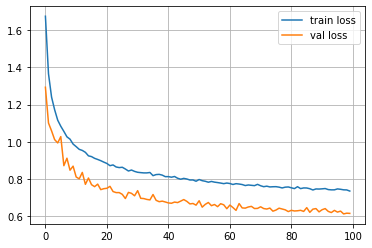

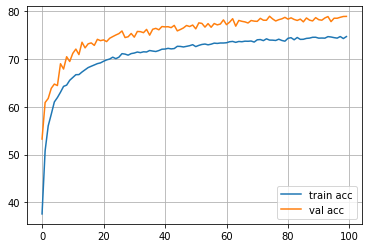

max train acc: 74.66000000000001	 max test acc: 78.9


In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data augmentation
stats = (3*[0.5],3*[0.5])
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# Data loader
train_loader,val_loader,classes = dataloader(batch_size, transform=(train_tfms,valid_tfms))

# define network for training
net = Net4().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

# Experiment 7: Better Model: Data Augmentation + BatchNorm (after ReLU)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Epoch: 1]     train loss: 1.634; val loss: 1.294;     train accuracy: 39.57%; test accuracy: 53.41%
[Epoch: 2]     train loss: 1.349; val loss: 1.103;     train accuracy: 51.50%; test accuracy: 60.93%
[Epoch: 3]     train loss: 1.234; val loss: 1.020;     train accuracy: 56.06%; test accuracy: 64.07%
[Epoch: 4]     train loss: 1.157; val loss: 0.983;     train accuracy: 59.27%; test accuracy: 64.89%
[Epoch: 5]     train loss: 1.101; val loss: 0.911;     train accuracy: 61.57%; test accuracy: 67.80%
[Epoch: 6]     train loss: 1.064; val loss: 0.859;     train accuracy: 62.89%; test accuracy: 70.15%
[Epoch: 7]     train loss: 1.033; val loss: 0.814;     train accuracy: 64.11%; test accuracy: 71.78%
[Epoch: 8]     train loss: 1.007; val loss: 0.863;     train accuracy: 65.05%; test accuracy: 69.99%
[Epoch: 9]     train loss: 0.978; val loss: 0.808;     train accuracy: 66.00%; test accuracy: 71.72%
[E

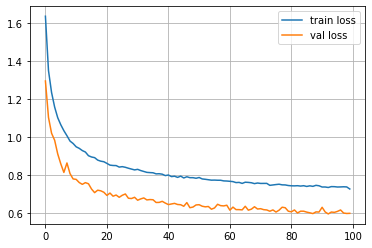

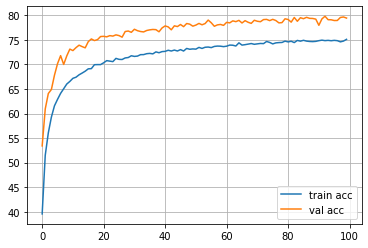

max train acc: 75.098	 max test acc: 79.8


In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data augmentation
stats = (3*[0.5],3*[0.5])
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# Data loader
train_loader,val_loader,classes = dataloader(batch_size, transform=(train_tfms,valid_tfms))

# define network for training
net = Net5().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

**Conclusion:** Batch Norm applied after ReLU improves test accuracy by 0.9% and training accuracy by ~0.4%. 

# Experiment 8: Learning Rate Decay

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 1.620; val loss: 1.250;     train accuracy: 40.32%; test accuracy: 54.25%
[Epoch: 2]     train loss: 1.334; val loss: 1.063;     train accuracy: 52.27%; test accuracy: 62.28%
[Epoch: 3]     train loss: 1.221; val loss: 1.023;     train accuracy: 56.59%; test accuracy: 63.40%
[Epoch: 4]     train loss: 1.147; val loss: 0.980;     train accuracy: 59.21%; test accuracy: 64.98%
[Epoch: 5]     train loss: 1.101; val loss: 0.895;     train accuracy: 61.48%; test accuracy: 68.68%
[Epoch: 6]     train loss: 1.062; val loss: 0.929;     train accuracy: 63.03%; test accuracy: 67.29%
[Epoch: 7]     train loss: 1.040; val loss: 0.883;     train accuracy: 63.62%; test accuracy: 69.26%
[Epoch: 8]     train loss: 1.008; val loss: 0.855;     train accuracy: 64.66%; test accuracy: 69.84%
[Epoch: 9]     train loss: 0.982; val loss: 0.856;     train accuracy: 65.71%; test accuracy: 69.42%
[Epoch: 10]    

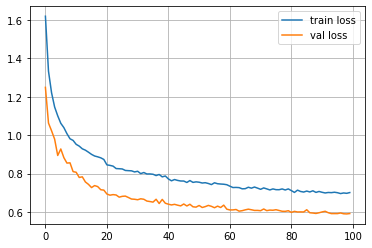

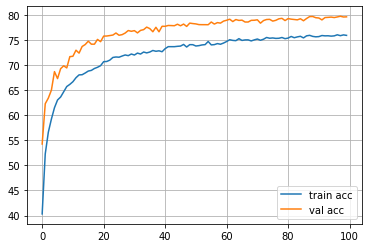

max train acc: 76.022	 max test acc: 79.72


In [10]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data augmentation
stats = (3*[0.5],3*[0.5])
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# Data loader
train_loader,val_loader,classes = dataloader(batch_size, transform=(train_tfms,valid_tfms))

# define network for training
net = Net5().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.7)

# train
losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device,scheduler)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

**Conclusion:** Learning rate decay improved the test accuracy by +0.3% in one experiment. When repeated the experiment, the same improvement is not visible.

# Experiment 9: Adam

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 1.668; val loss: 1.303;     train accuracy: 39.05%; test accuracy: 52.03%
[Epoch: 2]     train loss: 1.405; val loss: 1.152;     train accuracy: 49.78%; test accuracy: 58.69%
[Epoch: 3]     train loss: 1.309; val loss: 1.098;     train accuracy: 53.76%; test accuracy: 61.27%
[Epoch: 4]     train loss: 1.257; val loss: 1.072;     train accuracy: 56.09%; test accuracy: 61.95%
[Epoch: 5]     train loss: 1.221; val loss: 0.991;     train accuracy: 57.62%; test accuracy: 65.34%
[Epoch: 6]     train loss: 1.202; val loss: 0.981;     train accuracy: 58.38%; test accuracy: 64.86%
[Epoch: 7]     train loss: 1.169; val loss: 0.955;     train accuracy: 59.98%; test accuracy: 67.03%
[Epoch: 8]     train loss: 1.152; val loss: 0.947;     train accuracy: 60.37%; test accuracy: 66.50%
[Epoch: 9]     train loss: 1.131; val loss: 0.915;     train accuracy: 61.43%; test accuracy: 67.87%
[Epoch: 10]    

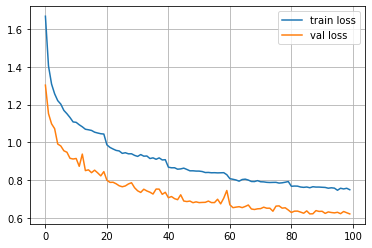

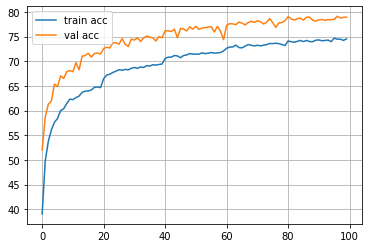

max train acc: 74.67200000000001	 max test acc: 79.11


In [ ]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9 #SGD
beta1,beta2 = 0.9,0.999
batch_size = 32
n_epochs = 100

# Data augmentation
stats = (3*[0.5],3*[0.5])
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# Data loader
train_loader,val_loader,classes = dataloader(batch_size, transform=(train_tfms,valid_tfms))

# define network for training
net = Net5().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1,beta2))

# Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.7)

# train
net, losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device,scheduler)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

**Conclusion:** Adam has not performed better than SGD. Test accuracy reduced by 1%.

# Experiment 10: SGD + Larger (Wider) Model

Files already downloaded and verified
Files already downloaded and verified
[Epoch: 1]     train loss: 1.410; val loss: 1.055;     train accuracy: 48.61%; test accuracy: 61.94%
[Epoch: 2]     train loss: 1.081; val loss: 0.875;     train accuracy: 61.71%; test accuracy: 68.84%
[Epoch: 3]     train loss: 0.955; val loss: 0.810;     train accuracy: 66.13%; test accuracy: 71.71%
[Epoch: 4]     train loss: 0.875; val loss: 0.733;     train accuracy: 69.28%; test accuracy: 74.33%
[Epoch: 5]     train loss: 0.827; val loss: 0.685;     train accuracy: 71.04%; test accuracy: 76.23%
[Epoch: 6]     train loss: 0.786; val loss: 0.670;     train accuracy: 72.42%; test accuracy: 76.65%
[Epoch: 7]     train loss: 0.748; val loss: 0.657;     train accuracy: 73.73%; test accuracy: 77.34%
[Epoch: 8]     train loss: 0.715; val loss: 0.614;     train accuracy: 75.08%; test accuracy: 78.46%
[Epoch: 9]     train loss: 0.694; val loss: 0.625;     train accuracy: 75.67%; test accuracy: 78.30%
[Epoch: 10]    

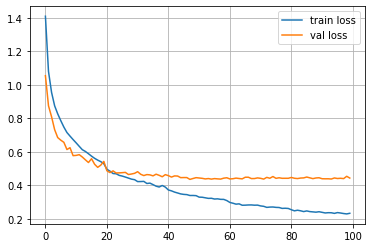

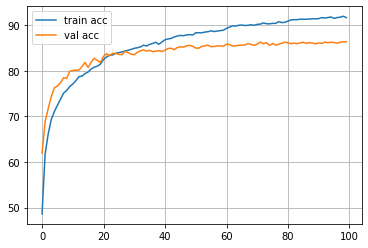

max train acc: 91.94	 max test acc: 86.34


In [10]:
# choose gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.005
momentum = 0.9
batch_size = 32
n_epochs = 100

# Data augmentation
stats = (3*[0.5],3*[0.5])
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# Data loader
train_loader,val_loader,classes = dataloader(batch_size, transform=(train_tfms,valid_tfms))

# define network for training
net = Net6().to(device)

# Loss function & optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum = momentum)

# Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.7)

# train
losses, acc, val_losses, val_acc = train(train_loader,val_loader,net,n_epochs,criterion,optimizer,device,scheduler)

# plot loss
plot_losses(losses, val_losses, acc, val_acc)

# accuracy
print(f'max train acc: {max(acc)}\t max test acc: {max(val_acc)}')

**Conclusion:** Reached best validation accuracy so far, but the model is over-fitting. More data augmentation and model weight decay (regularization) will likely help to improve.